# CNN with Bidirctional RNN - Char Classification
Using TensorFlow

## TODO
```
Everything
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.ops.rnn_cell_impl import LSTMCell, ResidualWrapper, DropoutWrapper, MultiRNNCell
import cv2


%matplotlib notebook
# Increase size of plots
plt.rcParams['figure.figsize'] = (9.0, 5.0)


# Helpers
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet
from ocr.imgtransform import coordinates_remap
from ocr.datahelpers import loadWordsData, correspondingShuffle

tf.reset_default_graph()
sess = tf.InteractiveSession()

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.13.1
TensorFlow: 1.2.1


## Loading Images

In [2]:
images, _, gaplines = loadWordsData(['data/words/'],
                                    loadGaplines=True)


Loading words...
Number of Images: 1008


## Settings

In [3]:
PAD = 0                            # Value for PADding images
POS = 1                            # Values of positive and negative label 0/-1
NEG = 0

POS_SPAN = 1                       # Number of positive values around true position

slider_size = (60, 30)             # Height is set to 60 by data and width should be even
slider_step = 2                    # Number of pixels slider moving
N_INPUT = 8*15*50                  # Size of sequence input vector will depend on CNN
num_buckets = 5
vocab_size = 2                     # Number of different outputs

rnn_layers = 2
rnn_residual_layers = 1            # HAVE TO be smaller than encoder_layers
rnn_units = 128

learning_rate = 1e-4               # 1e-4
dropout = 0.2                      # Percentage of dopped out data
train_set = 0.8                    # Percentage of training data

TRAIN_STEPS = 100000               # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64
EPOCH = 2000                       # "Number" of batches in epoch

## Dataset

In [4]:
# Shuffle data
images, gaplines = correspondingShuffle(images, gaplines)

for i in range(len(images)):
    # Add border and offset gaplines - RUN ONLY ONCE
    images[i] = cv2.copyMakeBorder(images[i],
                                   0, 0, int(slider_size[1]/2), int(slider_size[1]/2),
                                   cv2.BORDER_CONSTANT,
                                   value=0)
    gaplines[i] += int(slider_size[1] / 2)

# Split data on train and test dataset
div = int(train_set * len(images))

trainImages = images[0:div]
testImages = images[div:]

trainGaplines = gaplines[0:div]
testGaplines = gaplines[div:]

print("Training images:", div)
print("Testing images:", len(images) - div)

Training images: 806
Testing images: 202


In [ ]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images,
                 gaplines,
                 gap_span,
                 num_buckets=5,
                 slider=(60, 30),
                 imgprocess=lambda x: x,
                 train=True):
        
        self.train = train
        
        # First PADDING of images to slider size ( -(a // b) ==  ceil(a/b))
        self.slider = slider
        for i in images:
            i.resize((i.shape[0], -(-i.shape[1] // slider[1]) * slider[1]),
                     refcheck=False)
        in_length = [image.shape[1]//slider[1] for image in images]
        
        # Split images to sequence of vectors
        imgseq = np.empty(len(images), dtype=object)
        for i, img in enumerate(images):
            imgseq[i] = [imgprocess(img[:, loc * slider[1]: (loc+1) * slider[1]].flatten())
                         for loc in range(in_length[i])]

        # Create pandas dataFrame and sort it by images width (length) 
        self.dataFrame = pd.DataFrame({'in_length': in_length,
                                       'out_length': [len(t) for t in targets],
                                       'images': imgseq,
                                       'targets': targets
                                      }).sort_values('in_length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")

    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        input_max = max(res['in_length'])
        output_max = max(res['out_length'])
        assert input_max + 10 >= output_max   # In order to make it work at production
        
        input_seq = np.zeros((batch_size, input_max, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['in_length'].values[i]] = img
        input_seq = input_seq.swapaxes(0, 1)
        
        # Need to pad according to the maximum length output sequence
        targets = np.zeros([batch_size, output_max], dtype=np.int32)
        for i, target in enumerate(targets):
            target[:res['out_length'].values[i]] = res['targets'].values[i]
        targets = targets.swapaxes(0, 1)
        
        return input_seq, targets, res['in_length'].values, res['out_length'].values
    
    def next_feed(self, size):
        """ Create feed directly for model training """
        (encoder_inputs_,
         decoder_targets_,
         encoder_inputs_length_,
         decoder_targets_length_) = self.next_batch(size)
        return {
            encoder_inputs: encoder_inputs_,
            encoder_inputs_length: encoder_inputs_length_,
            decoder_targets: decoder_targets_,
            decoder_targets_length: decoder_targets_length_,
            keep_prob: 1.0 - dropout if self.train else 1.0
        }

In [ ]:
# Create iterator for feeding BiRNN
train_iterator = BucketDataIterator(trainImages,
                                    trainGaplines,
                                    POS_SPAN,
                                    num_buckets,
                                    slider_size,
                                    train=True)
test_iterator = BucketDataIterator(testImages,
                                   testGaplines,
                                   POS_SPAN,
                                   num_buckets,
                                   slider_size,
                                   train=False)

# Create classifier

## Convulation Neural Network

### Graph

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# Functions for initializing convulation and pool layers
def conv2d(x, W, name=None):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name=None):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

# Regularization scale - FOR TWEAKING
SCALE = 0.1

# Place holders for data (x) and labels (y_)
x = tf.placeholder(tf.float32, [None, 4096], name='x')
y_ = tf.placeholder(tf.float32, [None, CLAS])

# Reshape data
x_image = tf.reshape(x, [-1, 64, 64, 1])

# 1. Layer - Convulation + Subsampling
W_conv1 = tf.get_variable('W_conv1', shape=[5, 5, 1, 10],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv1 = tf.Variable(tf.constant(0.1, shape=[10]), name='b_conv1')

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1, name='h_conv1')    

# 2. Layer - Max Pool
h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')    

# 3. Layer - Convulation + Subsampling
W_conv2 = tf.get_variable('W_conv2', shape=[5, 5, 10, 20],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv2 = tf.Variable(tf.constant(0.1, shape=[20]), name='b_conv2')

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2, name='h_conv2')    

# 4. Layer - Max Pool
h_pool2 = max_pool_2x2(h_conv2, name='h_pool2')    

# 5. Layer - Convulation + Subsampling
W_conv3 = tf.get_variable('W_conv3', shape=[3, 3, 20, 40],
                          initializer=tf.contrib.layers.xavier_initializer())
b_conv3 = tf.Variable(tf.constant(0.1, shape=[40]), name='b_conv3')

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3, name='h_conv3')    

# 6. Layer - Max Pool
h_pool3 = max_pool_2x2(h_conv3, name='h_pool3')

# Reshape filters into flat arraty
h_flat = tf.reshape(h_pool3, [-1, 8*8*40], name='h_flat')    

# 7. Fully Connected layer
W_fc1 = tf.get_variable('W_fc1', shape=[8*8*40, 80],
                        initializer=tf.contrib.layers.xavier_initializer(),
                        regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[80]), name='b_fc1')

h_fc1 = tf.nn.relu(tf.matmul(h_flat, W_fc1) + b_fc1, name='h_fc1')    

# 8. Dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob, name='h_fc1_drop')

# 9. Output layer
W_fc2 = tf.get_variable('W_fc2', shape=[80, CLAS],
                        initializer=tf.contrib.layers.xavier_initializer(),
                        regularizer=tf.contrib.layers.l2_regularizer(scale=SCALE))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[CLAS]), name='b_fc2')

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2


# Creating activation function for using the model when imported
activation = tf.argmax(tf.matmul(h_fc1, W_fc2) + b_fc2, 1, name='activation')


# Cost: cross entropy + regularization
# Regularization with L2 Regularization with decaying learning rate
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_)
regularization = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
cost = tf.reduce_mean(cross_entropy) + sum(regularization)


# Optimizing model parametrs
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)


# Measuring accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training

<IPython.core.display.Javascript object>


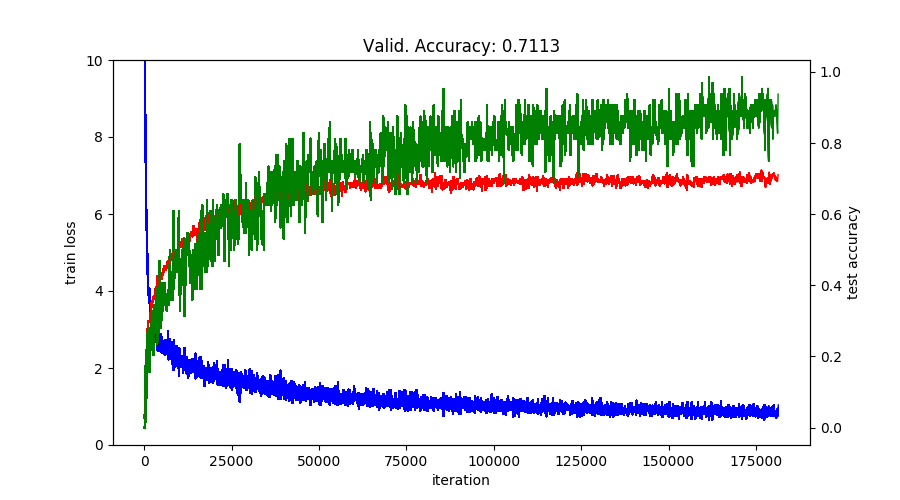

Accuracy 0.695985
Kernel interrupted, model saved
Accuracy 0.695985


In [9]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Set the logs writer to the folder and save graph for Tensorboard
summary_writer = tf.summary.FileWriter('logs', sess.graph)

### SETTINGS  ###
TRAIN_STEPS = 1000000
TEST_ITER = 150
COST_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, COST_ITER)

try:
    for i in range(TRAIN_STEPS):
        trainBatch, labelBatch = trainSet.next_batch(BATCH_SIZE)


        if i%COST_ITER == 0:
            # Plotting cost
            tmpCost = cost.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
            trainPlot.updateCost(tmpCost, i // COST_ITER)

        if i%TEST_ITER == 0:
            # Plotting accuracy
            accEval = accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0})
            accTrain = accuracy.eval(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 1.0})
            trainPlot.updateAcc(accEval, accTrain, i // TEST_ITER)

        if i%SAVE_ITER == 0:
            saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier')

        train_step.run(feed_dict={x: trainBatch, y_: labelBatch, keep_prob: 0.4})
        
except KeyboardInterrupt:
    saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier')
    print("Accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))
    print("Kernel interrupted, model saved")

    
# Final Save
saver.save(sess, 'models/char-clas/' + LANG + '/CharClassifier')

print("Accuracy %g" % accuracy.eval(feed_dict={x: evalData, y_: evalLabels, keep_prob: 1.0}))